# Linear Regression
- 집값 예측 문제에 해당하며, linear regression model을 사용하여 예측할 예정

## 순서
1. Importing and Viewing data
2. Initial EDA
3. Handling Null Value
4. Check the duplicated data
5. Dropping Outliers
6. Feature selection
  - Numerical and categorical data
  - Mapping Numeric Values to Ordinal Values
  - Distribution transformation
  - Min-Max Scaling
  - Correlation analysis
7. Modeling
  - Linear Regression
  - Xgboost

In [ ]:
# google drive 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change directory
%cd /content/drive/MyDrive/숙제/housing_price

/content/drive/MyDrive/숙제/housing_price


In [ ]:
!cd /content/drive/MyDrive/숙제/housing_price

In [ ]:
# zip 파일 압축 해제
# !unzip housing_price.zip

- `train.csv`: 모델 학습용 파일
- `test.csv`: 모델 테스트용 파일
- `sample_submission.csv`: 제출용 파일

## 1.Importing and Viewing data

In [ ]:
# Importing the necessary libraries
import os
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from time import time
from math import sqrt

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression

import xgboost
from xgboost.sklearn import XGBRegressor

In [ ]:
# 해당 directory에 있는 하위 폴더 확인
os.listdir('/content/drive/MyDrive/숙제/housing_price/housing_price')

['train.csv', 'test.csv', 'sample_submission.csv']

In [ ]:
# Read the cvs file
df_train = pd.read_csv("/content/drive/MyDrive/숙제/housing_price/housing_price/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/숙제/housing_price/housing_price/test.csv")

In [ ]:
sub = pd.read_csv("/content/drive/MyDrive/숙제/housing_price/housing_price/sample_submission.csv")
sub.head()

,id,target
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


## 2. Initial EDA

In [ ]:
# Dataframe 구조로 앞의 5개 행 확인
df_train.head()

,id,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
0,1,10,2392,Ex,3,968,Ex,2392,2392,Ex,2,2003,2003,2003,386250
1,2,7,1352,Gd,2,466,Gd,1352,1352,Ex,2,2006,2007,2006,194000
2,3,5,900,TA,1,288,TA,864,900,TA,1,1967,1967,1967,123000
3,4,5,1174,TA,2,576,Gd,680,680,TA,1,1900,2006,2000,135000
4,5,7,1958,Gd,3,936,Gd,1026,1026,Gd,2,2005,2005,2005,250000


- 예측해야하는 `target` column은 `price`으로 집의 가격이다.
- `train.csv`를 활용하여 모델을 학습 시킨 뒤, `test.csv` 파일의 데이터에 대해 `price`를 예측해서 `sample_submission.csv` 형식에 맞는 형태로 만드는 것

In [ ]:
# Check the number of rows and columns
print('train data dim {}:'.format(df_train.shape))
print('test data dim {}'.format(df_test.shape))

train data dim (1350, 15):
test data dim (1350, 14)


In [ ]:
# 12 columns are numerical now, without cleaning
df_train.describe()

,id,Overall Qual,Gr Liv Area,Garage Cars,Garage Area,Total Bsmt SF,1st Flr SF,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
count,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000
mean,675.500000,6.208889,1513.542222,1.870370,502.014815,1082.644444,1167.474074,1.560741,1972.987407,1985.099259,1978.471852,186406.312593
std,389.855743,1.338015,487.523239,0.652483,191.389956,384.067713,375.061407,0.551646,29.307257,20.153244,25.377278,78435.424758
min,1.000000,2.000000,480.000000,1.000000,100.000000,105.000000,480.000000,0.000000,1880.000000,1950.000000,1900.000000,12789.000000
25%,338.250000,5.000000,1144.000000,1.000000,368.000000,816.000000,886.250000,1.000000,1955.000000,1968.000000,1961.000000,135000.000000
50%,675.500000,6.000000,1445.500000,2.000000,484.000000,1009.000000,1092.500000,2.000000,1976.000000,1993.000000,1978.500000,165375.000000
75%,1012.750000,7.000000,1774.500000,2.000000,588.000000,1309.500000,1396.500000,2.000000,2002.000000,2004.000000,2002.000000,217875.000000
max,1350.000000,10.000000,4476.000000,5.000000,1488.000000,2660.000000,2898.000000,4.000000,2010.000000,2010.000000,2207.000000,745000.000000


In [ ]:
# train dataset columns 확인
df_train.columns

Index(['id', 'Overall Qual', 'Gr Liv Area', 'Exter Qual', 'Garage Cars',
       'Garage Area', 'Kitchen Qual', 'Total Bsmt SF', '1st Flr SF',
       'Bsmt Qual', 'Full Bath', 'Year Built', 'Year Remod/Add',
       'Garage Yr Blt', 'target'],
      dtype='object')

In [ ]:
# getting baseline stats on target('saleprice')
df_train['target'].describe()

count      1350.000000
mean     186406.312593
std       78435.424758
min       12789.000000
25%      135000.000000
50%      165375.000000
75%      217875.000000
max      745000.000000
Name: target, dtype: float64

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1350 non-null   int64 
 1   Overall Qual    1350 non-null   int64 
 2   Gr Liv Area     1350 non-null   int64 
 3   Exter Qual      1350 non-null   object
 4   Garage Cars     1350 non-null   int64 
 5   Garage Area     1350 non-null   int64 
 6   Kitchen Qual    1350 non-null   object
 7   Total Bsmt SF   1350 non-null   int64 
 8   1st Flr SF      1350 non-null   int64 
 9   Bsmt Qual       1350 non-null   object
 10  Full Bath       1350 non-null   int64 
 11  Year Built      1350 non-null   int64 
 12  Year Remod/Add  1350 non-null   int64 
 13  Garage Yr Blt   1350 non-null   int64 
 14  target          1350 non-null   int64 
dtypes: int64(12), object(3)
memory usage: 158.3+ KB


## 3. Handling Null Value

In [ ]:
# null 값 확인
df_train.isnull().sum()
# DataFrame.isnull()은 데이터마다 결측치 여부를 True, False로 반환하고, sum()을 통해 개수 확인 가능

id                0
Overall Qual      0
Gr Liv Area       0
Exter Qual        0
Garage Cars       0
Garage Area       0
Kitchen Qual      0
Total Bsmt SF     0
1st Flr SF        0
Bsmt Qual         0
Full Bath         0
Year Built        0
Year Remod/Add    0
Garage Yr Blt     0
target            0
dtype: int64

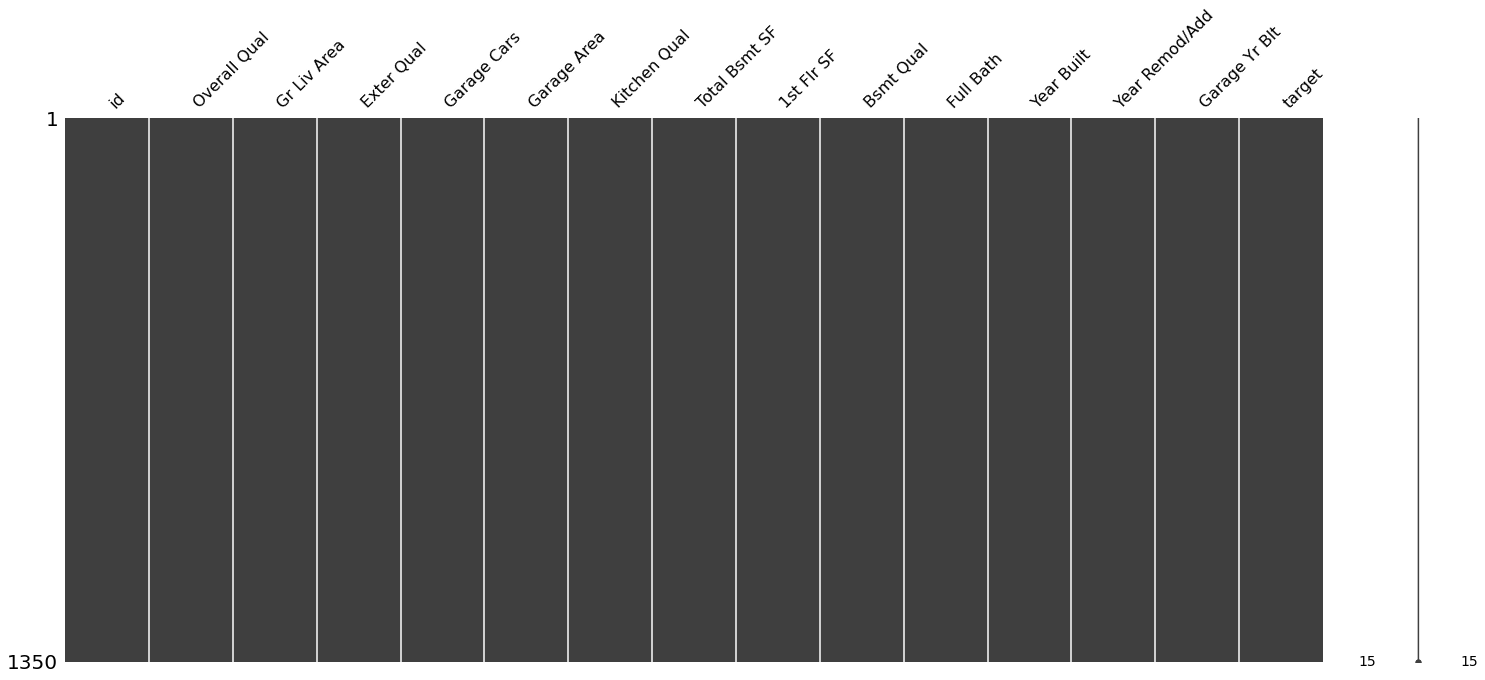

In [ ]:
# data 결측치로 시각화하여 확인할 수 있는 라이브러리 -> NaN 값이 있으면 하얀 줄로 뜸
msno.matrix(df_train)

In [ ]:
df_test.isnull().sum()

id                0
Overall Qual      0
Gr Liv Area       0
Exter Qual        0
Garage Cars       0
Garage Area       0
Kitchen Qual      0
Total Bsmt SF     0
1st Flr SF        0
Bsmt Qual         0
Full Bath         0
Year Built        0
Year Remod/Add    0
Garage Yr Blt     0
dtype: int64

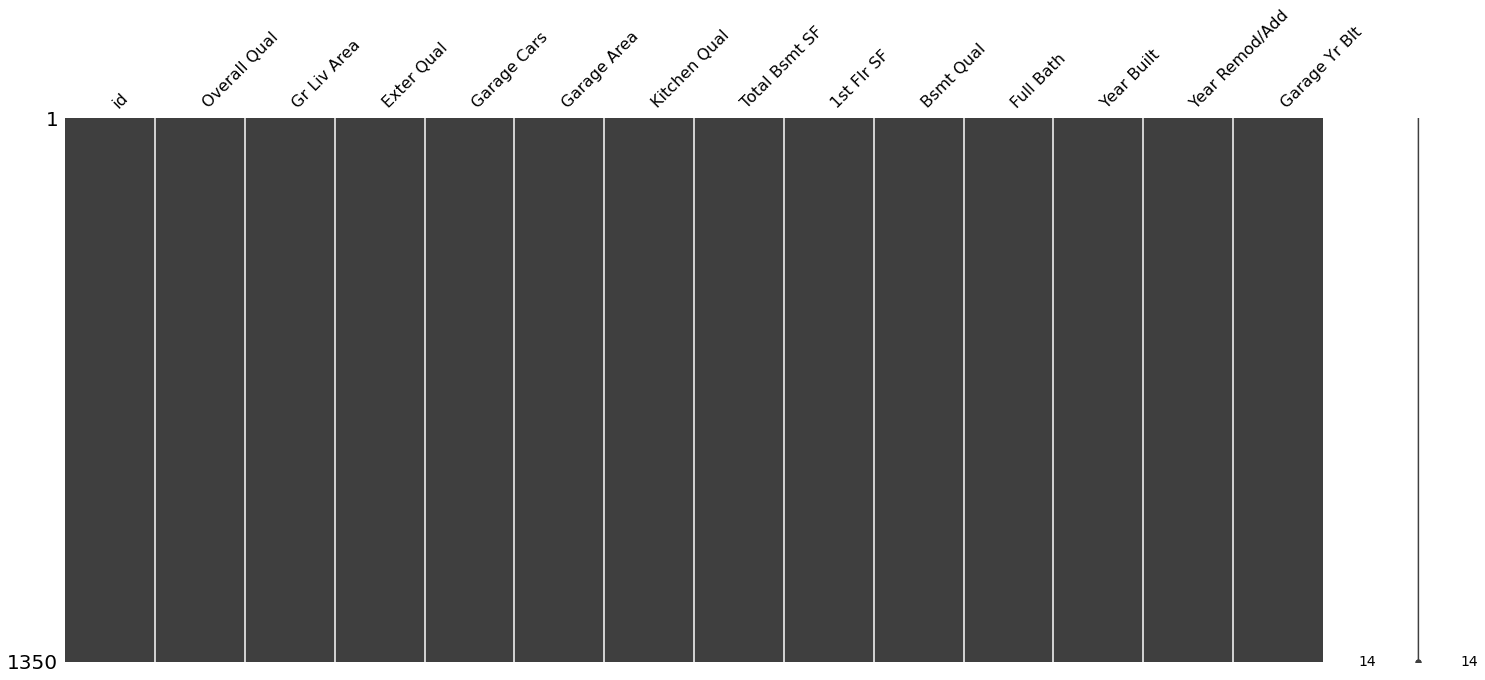

In [ ]:
msno.matrix(df_test)

## 4. Check the duplicated data

In [ ]:
# 데이터 중복값 확인 -> 있다면 DataFrame.drop_duplicates 사용
df_train.duplicated().sum()

0

In [ ]:
df_train.duplicated().sum()

0

## 5. Feature selection

## id

- `id`는 모델이 집값을 예측하는데 도움을 주지 않음
- 결과 제출을 위해 sub_id 변수에 column 저장

In [ ]:
train_len = len(df_train)
sub_id = df_train['id'][train_len:]
del df_train['id']
del df_test['id']

In [ ]:
print(df_train.columns) # column명 확인
print(df_train.shape) # shape 확인

Index(['Overall Qual', 'Gr Liv Area', 'Exter Qual', 'Garage Cars',
       'Garage Area', 'Kitchen Qual', 'Total Bsmt SF', '1st Flr SF',
       'Bsmt Qual', 'Full Bath', 'Year Built', 'Year Remod/Add',
       'Garage Yr Blt', 'target'],
      dtype='object')
(1350, 14)


In [ ]:
print(df_test.columns)
print(df_test.shape)

Index(['Overall Qual', 'Gr Liv Area', 'Exter Qual', 'Garage Cars',
       'Garage Area', 'Kitchen Qual', 'Total Bsmt SF', '1st Flr SF',
       'Bsmt Qual', 'Full Bath', 'Year Built', 'Year Remod/Add',
       'Garage Yr Blt'],
      dtype='object')
(1350, 13)


### Numerical and categorical data

In [ ]:
df_train.index

RangeIndex(start=0, stop=1350, step=1)

In [ ]:
# numerical columns
numerical_feats = df_train.dtypes[df_train.dtypes != 'object'].index
# 조건에 해당하는 경우, index명이 변수 안에 담기게 됨

# the number of numerical columns
print('Number of Numerical features: ', len(numerical_feats))

# check index
print(numerical_feats)

Number of Numerical features:  11
Index(['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area',
       'Total Bsmt SF', '1st Flr SF', 'Full Bath', 'Year Built',
       'Year Remod/Add', 'Garage Yr Blt', 'target'],
      dtype='object')


In [ ]:
# categorical columns
categorical_feats = df_train.dtypes[df_train.dtypes == 'object'].index
# the number of numerical columns
print('Number of Categorical features: ', len(categorical_feats))
# check index
print(categorical_feats)

Number of Categorical features:  3
Index(['Exter Qual', 'Kitchen Qual', 'Bsmt Qual'], dtype='object')


### Dropping Outliers

회귀 추정 문제에서 outlier는 모델과 결과의 예측력을 왜곡할 수 있다. 관측값이 엄청 크거나 엄청 작은 경우, 선형 관계에 큰 영향을 미치는데 이는 손실함수를 최소화하려고 하기 때문이다.

아래 method로 삭제하는 방법을 선택하였으나, 단순히 outlier를 삭제하는 것은 최선의 방법이 아닐 수도 있다고 한다.

<br/>

**전처리 과정**에서 고려해볼만한 점은

1. 해당 dataset은 변수가 많은 경우에 해당하기 때문에, PCA 등으로 차원을 축소하거나 변수 중요도를 파악 후 불필요한 변수를 제거해주는 방법
2. 편향된 변수가 존재하는지 확인하고 log, sqrt 등 함수로 분포를 변환 시켜주는 것
3. 측정 단위(scale)이 큰 경우, standard scale 이나 MinMaxScaler 통해 스케일링하는 것
4. categorical feature을 encoding하는 방법이 있고, 이는 모델이 해당 feature를 이해할 수 있도록 수치로 변환해주는 과정을 의미한다.

이번에는 **outlier 제거**, **feature scaling**, **categorical feature encoding**등을 수행하였다.

<br/>
  
### method
1. z-score
  - robust 하지 못함. 평균과 표준편차가 outlier에 크게 영향을 받음
  - 작은 dataset의 경우 z-score로 outlier를 찾기 힘듦
2. IQR

  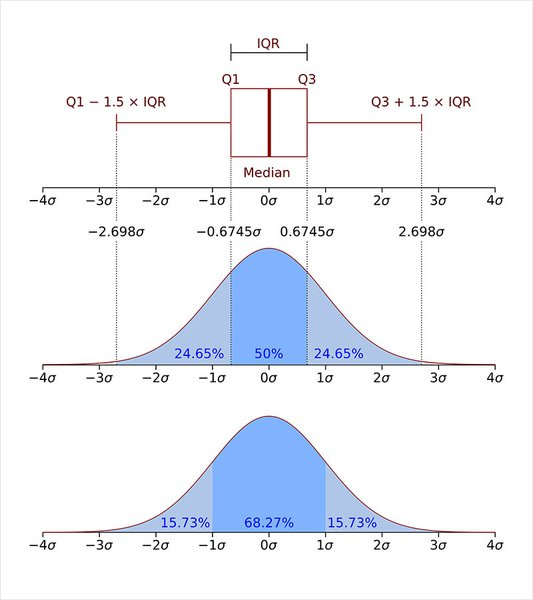

  - IQR은 4분위 범위수로 이상치를 찾는 방법이다.
  - $IQR = Q_3 - Q_1$
  - IQR은 제 3분위수에서 제 1사분위 값을 뺀 값으로 중간 50% 범위

In [ ]:
def detect_outliers(df, n, features):
    # outlier index를 담을 빈 리스트
    outlier_indices = []
    # features 안에서 column 하나씩 빼기 (categorical and numerical features)
    for col in features:
        # 25%에 해당되는 1분위 수, numpy의 percentile로 columns의 % 비율 표시
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        # IQR은 중간 50%의 범위로 Q3에서 Q1을 뺀 값
        IQR = Q3 - Q1
        
        # 범위를 적용할 값을 step에 담아줌
        outlier_step = 1.5 * IQR
        
        # outlier_step을 각각 더하고 뺀 값 이용
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        # extend는 리스트 가장 끝에 iterable의 각 항목을 추가함
        outlier_indices.extend(outlier_list_col)
    
    # 리스트 원소들의 개수를 세는 Counter (collections 모듈)
    outlier_indices = Counter(outlier_indices)
    # key, value 쌍을 얻는 items() - Counter를 통해 '원소'와 '개수'가 튜플 형태로 반환되기 때문
    # 이 쌍들을 list로 바꿔준다. 단, 개수가 n보다 많을 때(n은 해당 함수의 매개변수이며 최소 개수)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
      
    return multiple_outliers

In [ ]:
# 최소 2개 이상의 outlier가 있는 경우
Outlier_to_drop = detect_outliers(df_train, 2, numerical_feats)

In [ ]:
df_train.loc[Outlier_to_drop]

,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
297,7,2840,Gd,4,1314,Gd,1420,1420,Gd,2,1978,1978,1978,292500
735,7,2787,TA,4,820,TA,1168,1168,Ex,4,2000,2000,2000,269500
856,10,4476,Gd,3,813,Ex,2396,2411,Ex,3,1996,1996,1996,745000
939,7,2787,TA,4,820,TA,1168,1168,Ex,4,2000,2000,2000,269500
0,10,2392,Ex,3,968,Ex,2392,2392,Ex,2,2003,2003,2003,386250
380,8,2122,Gd,3,938,Gd,2108,2122,Gd,2,2007,2007,2007,345474
732,9,2338,Ex,3,1110,Gd,2660,2338,Ex,2,2006,2007,2005,591587
1002,9,2276,Gd,3,1348,Ex,2271,2276,Gd,2,2008,2008,2008,475000
1298,10,2084,Ex,3,1220,Ex,2078,2084,Ex,2,2007,2008,2007,385000
163,8,2522,Gd,2,564,Gd,2208,2522,Ex,2,2004,2005,2004,375000


In [ ]:
df_train = df_train.drop(Outlier_to_drop, axis=0).reset_index(drop=True)
df_train.shape

(1335, 14)

In [ ]:
# 최소 2개 이상의 outlier가 있는 경우
Outlier_to_drop = detect_outliers(df_test, 2, numerical_feats[:-1])

In [ ]:
df_test.loc[Outlier_to_drop]

,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt
34,10,2633,Ex,3,804,Ex,2633,2633,Ex,2,2001,2002,2001
95,10,4316,Ex,3,832,Ex,2444,2444,Ex,3,1994,1995,1994
170,10,5642,Ex,2,1418,Ex,6110,4692,Ex,2,2008,2008,2008
254,10,4676,Ex,3,884,Ex,3138,3138,Ex,3,2007,2008,2007
353,8,3228,Gd,2,546,Gd,3200,3228,Gd,3,1992,1993,1992
646,10,2790,Ex,4,1150,Ex,1620,1632,Ex,2,2005,2006,2005
906,10,5095,Ex,3,1154,Ex,5095,5095,Ex,2,2008,2009,2008
962,7,2787,TA,4,820,TA,1168,1168,Ex,4,2000,2000,2000
1104,9,2696,Ex,3,958,Ex,2846,2696,Ex,2,2003,2004,2003
1124,10,2674,Ex,3,762,Ex,2630,2674,Ex,2,2007,2007,2007


In [ ]:
df_test = df_test.drop(Outlier_to_drop, axis=0).reset_index(drop=True)
df_test.shape

(1336, 13)

#### Delete `id` column
- outlier를 drop하기 전과 후 `id` column을 포함하고 빼고 시도해보았는데 train set에만 조금의 변화가 있었음
- `id`가 outlier에 영향을 준다는 의미인지?
- column 제거 후 `Outlier_to_drop` 함수 사용시
  - train set: 15행 제거 -> (1343, 14)
  - test set: 14행 제거 -> (1336, 14)
- Column 제거 전
  - train set: 15행 제거 -> (1335, 14)
  - test set: 14행 제거 -> (1336, 14)
- 근데 제출할 때 submission file에 id 값을 넣어주려면, 나중에 삭제하는 것이 맞는 것인가? id를 언제 삭제해주는 것이 맞는지는 확실히 잘 모르겠다.


### row, column 등을 drop하고 싶을 때

`DataFrame.drop(labels=None, axis=0, index=None, columns=None, level=None, inplace=False, errors='raise')`
- `label`: 삭제할 레이블명
- `axis=0`: 행/ axis=1 열
- `index`: 인덱스명 입력시 삭제
- `columns`: 컬럼명 입력하면 삭제
- `level`: multi index인 경우 레벨 지정
- `inplace`: 원본 바로 변경 여부
- `errors`: 삭제할 레이블 못 찾을 경우 오류를 띄울지 (`ignore`: 존재하는 레이블만 삭제)
- `axis=0` + `label` = `index`
- `axis=1` + `label` = `columns`

In [ ]:
# delete target(price) column
y_train = df_train['target']
del df_train['target']
print(df_train.columns)
print(y_train.shape)

Index(['Overall Qual', 'Gr Liv Area', 'Exter Qual', 'Garage Cars',
       'Garage Area', 'Kitchen Qual', 'Total Bsmt SF', '1st Flr SF',
       'Bsmt Qual', 'Full Bath', 'Year Built', 'Year Remod/Add',
       'Garage Yr Blt'],
      dtype='object')
(1335,)


- There is no 'NaN' in the data!
- Checked and dropped the outlier data.
- We are primarily interested in the price what features are more corrlelated with that.
- Next, we will encode categorical features.

## Mapping Numeric Values to Ordinal Values
### label encoding

In [ ]:
# check the categorical label
print(categorical_feats)
print(len(categorical_feats))

Index(['Exter Qual', 'Kitchen Qual', 'Bsmt Qual'], dtype='object')
3


In [ ]:
df_train[categorical_feats].head()

,Exter Qual,Kitchen Qual,Bsmt Qual
0,Gd,Gd,Ex
1,TA,TA,TA
2,TA,Gd,TA
3,Gd,Gd,Gd
4,Gd,Ex,Ex


- `Gd`, `Ta`, `Ex` 반복된 변수가 보임
- 다른 범주형 변수가 있는지 확인 필요

In [ ]:
# dataframe에서 중복을 제거하지 않고 값을 확인하는 방법
# 하지만 array 값이 모두 출력된다.
df_train[categorical_feats].values

array([['Gd', 'Gd', 'Ex'],
       ['TA', 'TA', 'TA'],
       ['TA', 'Gd', 'TA'],
       ...,
       ['TA', 'TA', 'TA'],
       ['TA', 'TA', 'Gd'],
       ['TA', 'TA', 'Gd']], dtype=object)

In [ ]:
# 각 value들의 개수 counting
print(df_train['Exter Qual'].value_counts())
print(df_train['Kitchen Qual'].value_counts())
print(df_train['Bsmt Qual'].value_counts())

TA    806
Gd    477
Ex     44
Fa      8
Name: Exter Qual, dtype: int64
TA    658
Gd    554
Ex    100
Fa     23
Name: Kitchen Qual, dtype: int64
TA    605
Gd    578
Ex    123
Fa     28
Po      1
Name: Bsmt Qual, dtype: int64


In [ ]:
# 중복을 제거하고 어떤 value가 있는지만 보고 싶을 때
print(df_train['Exter Qual'].unique())
print(df_train['Kitchen Qual'].unique())
print(df_train['Bsmt Qual'].unique())

['Gd' 'TA' 'Ex' 'Fa']
['Gd' 'TA' 'Ex' 'Fa']
['Ex' 'TA' 'Gd' 'Fa' 'Po']


- 범주형 변수를 가진 feature들 모두 다 3가지(`Gd`, `Ta`, `Ex`, `Fa`)의 공통 value를 가졌고, `Bsmt Qual` feature만 `Po`가 있음

각 변수 의미
- `Ex`: Excellent
- `Gd`: Good
- `Ta`: Average/Typical
- `Fa`: Fair
- `Po`: Poor

**어떻게 encoding 해줄 것인지?** <br/>
이런 변수는 척도간 등급이 있기 때문에 더미 변수로 바꿔주는 원핫인코딩(one-hot encoding)을 하는 것보단, 수치형 데이터로 바꿔주는 것이 더 적절하다.
- 더미변수란 독립변수를 0과 1로 변환한 변수를 의미
- 순서에 대한 정보(ordinal information)이 사라지기 때문
- 예를 들면, 1~5점 척도 정도로 측정을 해주는 방법

### Method 1
- use `LabelEncoder` in sklearn
- `LabelEncoder` can be used to normalize labels and it can also be used to transform non-numerical labels to numerical labels.
- [참고](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [ ]:
# from sklearn import preprocessing
# from sklearn.preprocessing import LabelEncoder

# for col in list(train_data[categorical_feats]):
#   le = LabelEncoder()
#   train_data[col] = le.fit_transform(train_data[col])
#   test_data[col] = le.fit_transform(test_data[col])

# train_data[categorical_feats].head()

- 하지만 위의 방법은 encoder가 랜덤으로 자동 labeling 한다는 특징이 있음
- 다른 방법을 찾아보다가 mapping으로 해결하는 방법을 찾았음
- [판다스 - 라벨링(Labeling)](https://steadiness-193.tistory.com/236#recentEntries)


### Method 2

- chainging object columns with ratings
- **mapping numerical scales**

In [ ]:
# ['TA' 'Gd' 'Ex' 'Fa']
# ['TA' 'Gd' 'Ex' 'Fa']
# ['TA' 'Gd' 'Ex' 'Fa' 'Po']

mapping_1 = {'Po': 1, 
           'Fa': 2, 
           'TA': 3, 
           'Gd': 4, 
           'Ex': 5}

mapping_2 = {'Fa': 2, 
           'TA': 3, 
           'Gd': 4, 
           'Ex': 5}

In [ ]:
df_train['Bsmt Qual'] = df_train['Bsmt Qual'].map(mapping_1)
df_train['Exter Qual'] = df_train['Exter Qual'].map(mapping_2)
df_train['Kitchen Qual'] = df_train['Kitchen Qual'].map(mapping_2)

In [ ]:
# check - 각 value들의 개수 counting
print(df_train['Exter Qual'].value_counts())
print(df_train['Kitchen Qual'].value_counts())
print(df_train['Bsmt Qual'].value_counts())

3    806
4    477
5     44
2      8
Name: Exter Qual, dtype: int64
3    658
4    554
5    100
2     23
Name: Kitchen Qual, dtype: int64
3    605
4    578
5    123
2     28
1      1
Name: Bsmt Qual, dtype: int64


**시행 착오** \
[nan] \
[3 4 5 2] \
[nan] \

- 처음에 5~1 이렇게 줄어들게끔 mapping dictionary를 만들어주었더니 저렇게 결과가 나옴
- mapping을 하는 dictionary 순서를 반대로 바꿔주니까 올바르게 됨!

In [ ]:
# test set에도 똑같이 적용
df_test['Bsmt Qual'] = df_test['Bsmt Qual'].map(mapping_1)
df_test['Exter Qual'] = df_test['Exter Qual'].map(mapping_2)
df_test['Kitchen Qual'] = df_test['Kitchen Qual'].map(mapping_2)

In [ ]:
# check - 각 value들의 개수 counting
print(df_test['Exter Qual'].value_counts())
print(df_test['Kitchen Qual'].value_counts())
print(df_test['Bsmt Qual'].value_counts())

3    793
4    488
5     46
2      9
Name: Exter Qual, dtype: int64
3.0    665
4.0    565
5.0     82
2.0     23
Name: Kitchen Qual, dtype: int64
4    596
3    582
5    111
2     46
1      1
Name: Bsmt Qual, dtype: int64


## corr

Text(0.5, 1.0, 'Correlations')

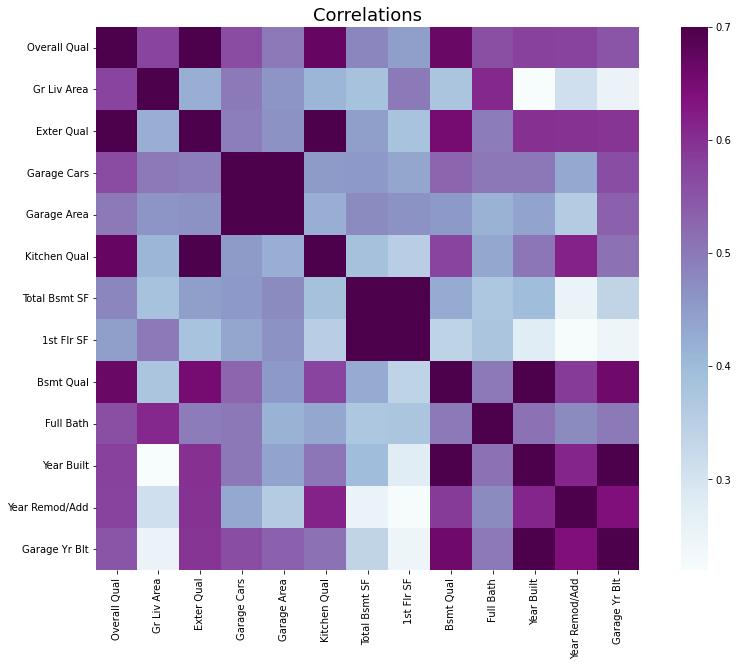

In [ ]:
corr = df_train.corr()
plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr, cmap='BuPu', vmax=0.7, square=True)
ax.set_title('Correlations', fontsize=18)

## Distribution transformation
- log transformation (Normalizing y)
- 회귀분석에서는 target 분포가 비대칭 형태인지 확인을 해야하는데, 보통 이상치 제거와 로그 변환으로 이루어진다고 한다.
- 현재 target은 집값이므로, 정규성을 띄긴 어려울 거라 예상

<br/>

편향된 분포의 변수가 존재하는 경우 skewness를 없애고 정규분포에 가깝게 하기 위해 큰 값에 penalty가 크면서 연속적이고 역함수가 존재하는 함수를 통해 변환이 가능하다.
- log, sqrt 등 함수로 분포 변환을 시켜줄 수 있다.
- 왜곡된 형태를 띄는 분포를 skewed라고 하고 예측 성능에 부정적인 영향을 미침

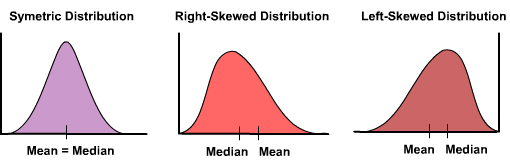

Sale Price is not normally distributed so lets try the LogSalePrice as the predicted variable

In [ ]:
y_train

0       194000
1       123000
2       135000
3       250000
4       269500
         ...  
1330    204000
1331    390000
1332    143000
1333    131000
1334    140000
Name: target, Length: 1335, dtype: int64

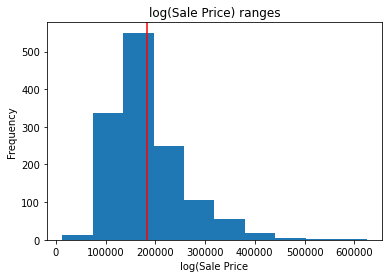

In [ ]:
plt.figure(figsize=(6,4))
plt.title('log(Sale Price) ranges')
plt.xlabel('log(Sale Price')
plt.ylabel('Frequency')
plt.hist(y_train)
plt.axvline(x=np.mean(y_train), color='red')

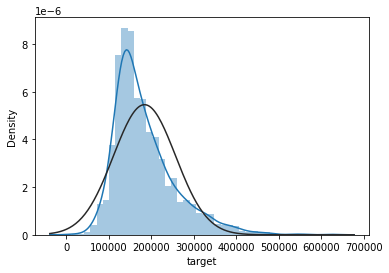

In [ ]:
sns.distplot(y_train, fit=stats.norm)

In [ ]:
y_log = np.log(y_train)
y_log

0       12.175613
1       11.719940
2       11.813030
3       12.429216
4       12.504324
          ...    
1330    12.225875
1331    12.873902
1332    11.870600
1333    11.782953
1334    11.849398
Name: target, Length: 1335, dtype: float64

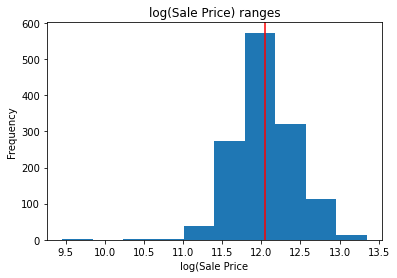

In [ ]:
plt.figure(figsize=(6,4))
plt.title('log(Sale Price) ranges')
plt.xlabel('log(Sale Price')
plt.ylabel('Frequency')
plt.hist(y_log)
plt.axvline(x=np.mean(y_log), color='red')

In [ ]:
y_train = y_log
y_train

0       12.175613
1       11.719940
2       11.813030
3       12.429216
4       12.504324
          ...    
1330    12.225875
1331    12.873902
1332    11.870600
1333    11.782953
1334    11.849398
Name: target, Length: 1335, dtype: float64

## Min-Max Scaling
- 데이터의 최솟값은 0, 최댓값은 1로 변환 시켜줌

$$
\frac{X-X_{min}}{X_{max}-X_{min}}
$$

- scaling을 진행시켜준 식은 위와 같음

In [ ]:
df_train.head()

,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt
0,7,1352,4,2,466,4,1352,1352,5,2,2006,2007,2006
1,5,900,3,1,288,3,864,900,3,1,1967,1967,1967
2,5,1174,3,2,576,4,680,680,3,1,1900,2006,2000
3,7,1958,4,3,936,4,1026,1026,4,2,2005,2005,2005
4,8,1968,4,3,680,5,774,774,5,2,2009,2010,2009


In [ ]:
print(df_train.shape)
print(df_test.shape)
print(y_train.shape)

(1335, 13)
(1336, 13)
(1335,)


In [ ]:
print(numerical_feats)
print(len(numerical_feats))

Index(['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area',
       'Total Bsmt SF', '1st Flr SF', 'Full Bath', 'Year Built',
       'Year Remod/Add', 'Garage Yr Blt', 'target'],
      dtype='object')
11


In [ ]:
# numerical_feats에 해당되는 target 값을 제외하고 다시 지정
numerical_feats = numerical_feats[:-1]
print(numerical_feats)
print(numerical_feats.shape)

Index(['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area',
       'Total Bsmt SF', '1st Flr SF', 'Full Bath', 'Year Built',
       'Year Remod/Add', 'Garage Yr Blt'],
      dtype='object')
(10,)


### Method

- 범주형 변수를 labeling한 값을 빼고 MinMax 정규화를 해야한다.
- 따로 진행하고 합쳐주는 방식
- 그리고 초반에 나눈 numerical and categorical feature에 따라 아무 생각 없이 scaling을 진행해주었는데, scaling이 필요한 feature만 따로 지정해서 scaling하는 것이 맞다고 판단 됨
- 기준은 어떻게 세울 것인가?

<br/>

### 어떤 feature만 scaling 해줄 것인지

numerical features에 속하는 컬럼들 중에,

'Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF'은 거의 면적에 해당하는 feature이므로 포함하고, 날짜와 관련되어 있는 features는 어떻게 해야 할지 고민

<br/>

**그 외 제외시킨 feature 이유**
- `Overall Qual`: Rates the overall material and finish of the house (rate에 해당되어서)
- `Garage Cars`: Garage Cars: Size of garage in car capacity(보유할 수 있는 차 개수)
- `Full Bath`: Full bathrooms above grade (개수)

<br/>

**날짜 관련 feature들을 어떻게 할지**

- 'Year Built': Original construction date
- 'Year Remod/Add': Remodel date (same as construction date if no remodeling or additions)
- 'Garage Yr Blt': Year garage was built

<br/>

**중간 정리**

- 아까 feature selection 부분에서 불필요한 feature들을 제외 시켜주는 작업이 필요했을 거라 생각
- 근데 년도 관련 정보는 언제 만들어진지도 중요한 feature가 아닐까 주관적인 판단
- 이들은 연속형 변수라는 특징을 갖고 있음
- target 값과 상관관계를 따져보는 것이 좋다고 판단

## Correlation analysis

자료는 구성하고 있는 값의 특성에 따라 종류가 나뉨
- 명목 척도(nominal scale)
- 순위 척도(ordinal scale)
- 간격 척도(interval scale)
- 비 척도(ratio scale)
  - 명목 척도와 순위 척도는 범주형 자료(categorical data)
  - 간격 척도외 비 척도(ratio scale)은 연속형 자료(continuous data)
로 분류 할 수 있다.

연속형 자료들끼리 분석하는 방법 중 가장 잘 알려진 것이 *상관 관계 분석*, *회귀 분석*이다.

- 상관관계는 [-1, 1] 값을 가지고, 양/음의 상관관계라 부름
- 양의 상관관계는 두 변수들 중 하나가 증가하면 증가하고, 감소하면 따라 감소하는 경향을 지닌 경우
- 음의 상관관계는 반대이다. 한 변수의 수치가 증가하면 다른 변수는 감소하는 경향을 보인다.

In [ ]:
# numerical만 포함한 df와 target을 합침
# 이유는 heatmap 설정을 실패해서 귀찮아서...
corr = pd.concat([df_train[numerical_feats], y_train], axis=1)
corr

,Overall Qual,Gr Liv Area,Garage Cars,Garage Area,Total Bsmt SF,1st Flr SF,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
0,7,1352,2,466,1352,1352,2,2006,2007,2006,12.175613
1,5,900,1,288,864,900,1,1967,1967,1967,11.719940
2,5,1174,2,576,680,680,1,1900,2006,2000,11.813030
3,7,1958,3,936,1026,1026,2,2005,2005,2005,12.429216
4,8,1968,3,680,774,774,2,2009,2010,2009,12.504324
...,...,...,...,...,...,...,...,...,...,...,...
1330,6,1756,2,422,872,888,2,1996,1997,1996,12.225875
1331,9,2748,3,850,1850,1850,2,2006,2006,2006,12.873902
1332,5,1214,1,318,1214,1214,2,1967,1967,1967,11.870600
1333,5,894,2,440,864,894,1,1974,1974,1974,11.782953


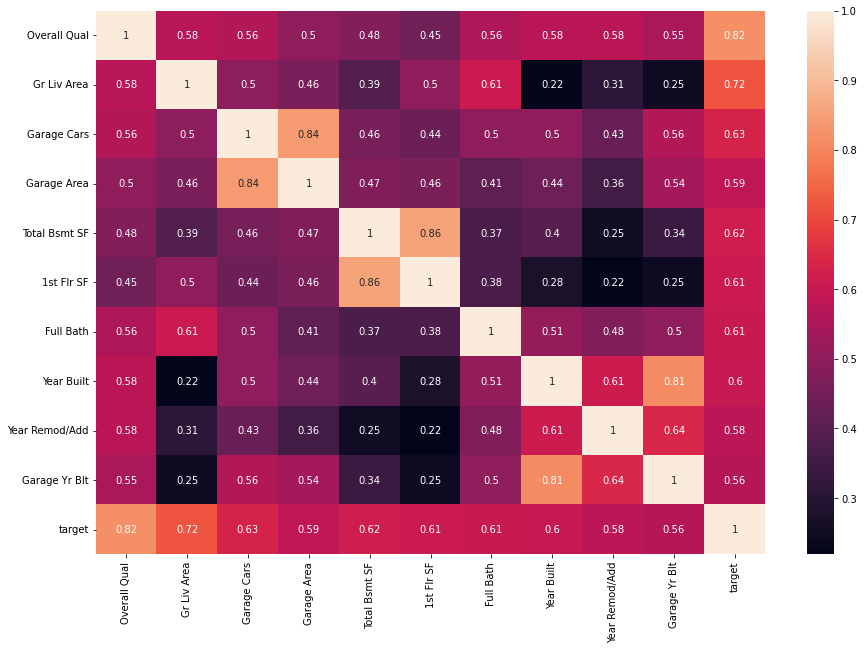

In [ ]:
plt.figure(figsize=(15,10))
ax = sns.heatmap(corr.corr(), annot=True)
plt.show()

- target과의 상관관계가 전반적으로 높은 편 같다. (상관계수로 판단)
- `Overall Qual(등급)`, `Gr Liv Area(면적)`, `Garage Cars` 순으로 높음
- 또한, 년도/차고 완공 년도 간의 상관계수도 높은 편이라 판단

In [ ]:
print('리모델링을 안 한 집:', sum(df_train['Year Built'] == df_train['Year Remod/Add']))
print('리모델링을 한 집:', sum(df_train['Year Built'] < df_train['Year Remod/Add']))
print('잘못된 데이터 확인:', sum(df_train['Year Built'] > df_train['Year Remod/Add']))

리모델링을 안 한 집: 732
리모델링을 한 집: 603
잘못된 데이터 확인: 0


In [ ]:
print('집과 차고를 같이 완공한 집:', sum(df_train['Year Built'] == df_train['Garage Yr Blt']))
print('차고를 늦게 지은 집:', sum(df_train['Year Built'] < df_train['Garage Yr Blt']))
print('차고를 먼저 지은 집:', sum(df_train['Year Built'] > df_train['Garage Yr Blt'])) 

집과 차고를 같이 완공한 집: 1061
차고를 늦게 지은 집: 264
차고를 먼저 지은 집: 10


- 리모델링을 하고, 집을 지었다는 이상한 데이터는 없음
- 차고를 먼저 지은 집이 10으로 굉장히 작기 때문에, 집과 같이 지었다는 데이터에 속하도록 수정

In [ ]:
# target이 필요해서 train data를 다시 불러오자
train = pd.read_csv("/content/drive/MyDrive/숙제/housing_price/housing_price/train.csv")
train

,id,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
0,1,10,2392,Ex,3,968,Ex,2392,2392,Ex,2,2003,2003,2003,386250
1,2,7,1352,Gd,2,466,Gd,1352,1352,Ex,2,2006,2007,2006,194000
2,3,5,900,TA,1,288,TA,864,900,TA,1,1967,1967,1967,123000
3,4,5,1174,TA,2,576,Gd,680,680,TA,1,1900,2006,2000,135000
4,5,7,1958,Gd,3,936,Gd,1026,1026,Gd,2,2005,2005,2005,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,1346,6,1756,Gd,2,422,TA,872,888,Ex,2,1996,1997,1996,204000
1346,1347,9,2748,Gd,3,850,Ex,1850,1850,Ex,2,2006,2006,2006,390000
1347,1348,5,1214,TA,1,318,TA,1214,1214,TA,2,1967,1967,1967,143000
1348,1349,5,894,TA,2,440,TA,864,894,Gd,1,1974,1974,1974,131000


In [ ]:
print('리모델링 한 집 가격:', train['target'][train['Year Built'] < train['Year Remod/Add']].mean())
print('리모델링 안 한 집 가격:',train['target'][train['Year Built'] == train['Year Remod/Add']].mean())

print('차고를 늦게 지은 집:',train['target'][train['Year Built'] < train['Garage Yr Blt']].mean())
print('집과 차고를 같이 완공한 집:', train['target'][train['Year Built'] >= train['Garage Yr Blt']].mean())

리모델링 한 집 가격: 183097.6589785832
리모델링 안 한 집 가격: 189109.34454912518
차고를 늦게 지은 집: 151515.625
집과 차고를 같이 완공한 집: 194888.02670349908


1. 리모델링을 안 한 집 가격이 더 높다는 점
2. 집과 차고를 같이 완공한 집의 가격이 훨씬 높다는 점

- 그렇다면 리모델링의 여부가 집값을 내리는데 더 영향을 준다는 것이기 때문에 음의 상관관계로 바꿔줌
- 또한, 차고를 늦게 지은 집도 집값을 내리는데 영향을 주기 때문에 음의 싱관관계로 바꿔줌
- 두 가지 경우의 수를 `-1`, `1`로 설정하고 scaling하기 애매하다고 판단되었던 date 관련 feature('Year Built', 'Year Remod/Add', 'Garage Yr Blt')를 지워주기로 함
- 이것도 encoding이라 그러는가 .. ?

In [ ]:
# 확인하기 위해 임시로 불러온 train(dataframe)이 아니라 원본에 적용 시켜줘야 하기 때문에 다시 df_train 사용

# df_train['Year Remod/Add']에서 리모델링을 한 집은 -1
df_train['Year Remod/Add'][df_train['Year Built'] < df_train['Year Remod/Add']] = -1
# df_train['Year Remod/Add']에서 리모델링을 안 한 집은 1
df_train['Year Remod/Add'][df_train['Year Built'] == df_train['Year Remod/Add']] = 1

# df_train['Garage Yr Blt']에서 차고를 늦게 지은 집 -1
df_train['Garage Yr Blt'][df_train['Year Built'] < df_train['Garage Yr Blt']] = -1
# df_train['Garage Yr Blt']에서 집과 차고를 같이 완공한 집 1
df_train['Garage Yr Blt'][df_train['Year Built'] >= df_train['Garage Yr Blt']] = 1

In [ ]:
df_train['Year Remod/Add']

0      -1
1       1
2      -1
3       1
4      -1
       ..
1330   -1
1331    1
1332    1
1333    1
1334    1
Name: Year Remod/Add, Length: 1335, dtype: int64

In [ ]:
df_train['Garage Yr Blt']

0       1
1       1
2       1
3       1
4       1
       ..
1330    1
1331    1
1332    1
1333    1
1334    1
Name: Garage Yr Blt, Length: 1335, dtype: int64

In [ ]:
# test에도 똑같이 적용
df_test['Year Remod/Add'][df_test['Year Built'] < df_test['Year Remod/Add']] = -1
df_test['Year Remod/Add'][df_test['Year Built'] == df_test['Year Remod/Add']] = 1
df_test['Garage Yr Blt'][df_test['Year Built'] < df_test['Garage Yr Blt']] = -1
df_test['Garage Yr Blt'][df_test['Year Built'] >= df_test['Garage Yr Blt']] = 1

In [ ]:
df_train.drop(labels='Year Built', axis=1, inplace=True)
df_test.drop(labels='Year Built', axis=1, inplace=True)
print(df_train.shape)
print(df_test.shape)

(1335, 12)
(1336, 12)


In [ ]:
# check train dataset
df_train

,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Remod/Add,Garage Yr Blt
0,7,1352,4,2,466,4,1352,1352,5,2,-1,1
1,5,900,3,1,288,3,864,900,3,1,1,1
2,5,1174,3,2,576,4,680,680,3,1,-1,1
3,7,1958,4,3,936,4,1026,1026,4,2,1,1
4,8,1968,4,3,680,5,774,774,5,2,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1330,6,1756,4,2,422,3,872,888,5,2,-1,1
1331,9,2748,4,3,850,5,1850,1850,5,2,1,1
1332,5,1214,3,1,318,3,1214,1214,3,2,1,1
1333,5,894,3,2,440,3,864,894,4,1,1,1


In [ ]:
# check test dataset
df_test

,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Remod/Add,Garage Yr Blt
0,9,1800,4,2,702,5.0,1800,1800,5,2,1,1
1,6,1082,3,1,240,3.0,1082,1082,3,1,-1,1
2,6,1573,4,2,440,4.0,756,769,4,2,1,1
3,6,2443,4,3,744,4.0,1158,1158,4,2,1,1
4,5,1040,3,2,686,3.0,1040,1040,3,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1331,8,1932,5,3,774,5.0,1932,1932,5,2,1,1
1332,5,912,3,1,288,3.0,912,912,3,1,1,1
1333,4,861,3,2,288,3.0,861,861,2,1,-1,1
1334,5,1430,3,2,624,4.0,1430,1430,5,2,-1,1


### 정리
연속형 변수들만 모아둔 numerical_feats를 따로 지정하고, 그 외 scaling을 하지 않는 feature들만 따로 빼서 나중에 concat하는 방식으로 진행
 

In [ ]:
all_features = ['Overall Qual', 'Gr Liv Area', 'Exter Qual', 'Garage Cars',
       'Garage Area', 'Kitchen Qual', 'Total Bsmt SF', '1st Flr SF',
       'Bsmt Qual', 'Full Bath', 'Year Remod/Add',
       'Garage Yr Blt']

In [ ]:
# 필요한 feature만 index로 만들어주었음
numerical = ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF']

In [ ]:
except_features = []

for col in all_features:
  for column in numerical:
    if col == column:
      all_features.remove(column)
  except_features = all_features

print(except_features)
print(len(except_features))

['Overall Qual', 'Exter Qual', 'Garage Cars', 'Kitchen Qual', 'Bsmt Qual', 'Full Bath', 'Year Remod/Add', 'Garage Yr Blt']
8


In [ ]:
# 수치형 변수들만 모아둔 dataframe
train_num = df_train[numerical]
train_num

,Gr Liv Area,Garage Area,Total Bsmt SF,1st Flr SF
0,1352,466,1352,1352
1,900,288,864,900
2,1174,576,680,680
3,1958,936,1026,1026
4,1968,680,774,774
...,...,...,...,...
1330,1756,422,872,888
1331,2748,850,1850,1850
1332,1214,318,1214,1214
1333,894,440,864,894


In [ ]:
# 범주형 변수들만 모아둔 dataframe
train_cate = df_train[except_features]
train_cate

,Overall Qual,Exter Qual,Garage Cars,Kitchen Qual,Bsmt Qual,Full Bath,Year Remod/Add,Garage Yr Blt
0,7,4,2,4,5,2,-1,1
1,5,3,1,3,3,1,1,1
2,5,3,2,4,3,1,-1,1
3,7,4,3,4,4,2,1,1
4,8,4,3,5,5,2,-1,1
...,...,...,...,...,...,...,...,...
1330,6,4,2,3,5,2,-1,1
1331,9,4,3,5,5,2,1,1
1332,5,3,1,3,3,2,1,1
1333,5,3,2,3,4,1,1,1


In [ ]:
# test set에 적용
test_num = df_test[numerical]
test_cate = df_test[except_features]
print(test_num.shape)
print(test_cate.shape)

(1336, 4)
(1336, 8)


In [ ]:
# MinMax scale은 수치형 변수에만 적용 시키려 했으므로
train_min = train_num.min()
train_max = train_num.max()

In [ ]:
train_min_max = (train_num - train_min)/(train_max - train_min)
test_min_max =  (test_num - train_min)/(train_max - train_min)
# test를 min-max scaling할 때도 train 정규화 기준으로 수행 - 이유❗

In [ ]:
train_min_max

,Gr Liv Area,Garage Area,Total Bsmt SF,1st Flr SF
0,0.277089,0.263689,0.515502,0.360629
1,0.133460,0.135447,0.313766,0.173697
2,0.220527,0.342939,0.237702,0.082713
3,0.469654,0.602305,0.380736,0.225806
4,0.472831,0.417867,0.276561,0.121588
...,...,...,...,...
1330,0.405466,0.231988,0.317073,0.168734
1331,0.720686,0.540346,0.721372,0.566584
1332,0.233238,0.157061,0.458454,0.303557
1333,0.131554,0.244957,0.313766,0.171216


In [ ]:
test_min_max

,Gr Liv Area,Garage Area,Total Bsmt SF,1st Flr SF
0,0.419447,0.433718,0.700703,0.545906
1,0.191293,0.100865,0.403886,0.248966
2,0.347315,0.244957,0.269119,0.119520
3,0.623769,0.463977,0.435304,0.280397
4,0.177947,0.422190,0.386523,0.231596
...,...,...,...,...
1331,0.461392,0.485591,0.755271,0.600496
1332,0.137274,0.135447,0.333609,0.178660
1333,0.121068,0.135447,0.312526,0.157568
1334,0.301875,0.377522,0.547747,0.392887


In [ ]:
# numerical과 except 분류했던 것 concat을 통해 다시 dataframe을 합쳐주고, 나머지가 뒤에 붙게 됨
df_train = pd.concat([train_min_max, train_cate], axis=1)
df_test = pd.concat([test_min_max, test_cate], axis=1)

In [ ]:
df_train

,Gr Liv Area,Garage Area,Total Bsmt SF,1st Flr SF,Overall Qual,Exter Qual,Garage Cars,Kitchen Qual,Bsmt Qual,Full Bath,Year Remod/Add,Garage Yr Blt
0,0.277089,0.263689,0.515502,0.360629,7,4,2,4,5,2,-1,1
1,0.133460,0.135447,0.313766,0.173697,5,3,1,3,3,1,1,1
2,0.220527,0.342939,0.237702,0.082713,5,3,2,4,3,1,-1,1
3,0.469654,0.602305,0.380736,0.225806,7,4,3,4,4,2,1,1
4,0.472831,0.417867,0.276561,0.121588,8,4,3,5,5,2,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1330,0.405466,0.231988,0.317073,0.168734,6,4,2,3,5,2,-1,1
1331,0.720686,0.540346,0.721372,0.566584,9,4,3,5,5,2,1,1
1332,0.233238,0.157061,0.458454,0.303557,5,3,1,3,3,2,1,1
1333,0.131554,0.244957,0.313766,0.171216,5,3,2,3,4,1,1,1


In [ ]:
df_test

,Gr Liv Area,Garage Area,Total Bsmt SF,1st Flr SF,Overall Qual,Exter Qual,Garage Cars,Kitchen Qual,Bsmt Qual,Full Bath,Year Remod/Add,Garage Yr Blt
0,0.419447,0.433718,0.700703,0.545906,9,4,2,5.0,5,2,1,1
1,0.191293,0.100865,0.403886,0.248966,6,3,1,3.0,3,1,-1,1
2,0.347315,0.244957,0.269119,0.119520,6,4,2,4.0,4,2,1,1
3,0.623769,0.463977,0.435304,0.280397,6,4,3,4.0,4,2,1,1
4,0.177947,0.422190,0.386523,0.231596,5,3,2,3.0,3,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1331,0.461392,0.485591,0.755271,0.600496,8,5,3,5.0,5,2,1,1
1332,0.137274,0.135447,0.333609,0.178660,5,3,1,3.0,3,1,1,1
1333,0.121068,0.135447,0.312526,0.157568,4,3,2,3.0,2,1,-1,1
1334,0.301875,0.377522,0.547747,0.392887,5,3,2,4.0,5,2,-1,1


In [ ]:
df_train.describe()

,Gr Liv Area,Garage Area,Total Bsmt SF,1st Flr SF,Overall Qual,Exter Qual,Garage Cars,Kitchen Qual,Bsmt Qual,Full Bath,Year Remod/Add,Garage Yr Blt
count,1335.000000,1335.000000,1335.000000,1335.000000,1335.000000,1335.000000,1335.000000,1335.000000,1335.000000,1335.000000,1335.000000,1335.0
mean,0.324598,0.286261,0.399274,0.279813,6.182022,3.417228,1.857678,3.547566,3.594757,1.553558,0.096629,1.0
std,0.150358,0.133814,0.151412,0.148636,1.316135,0.566826,0.641493,0.657519,0.687085,0.543409,0.995693,0.0
min,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000,1.000000,0.000000,-1.000000,1.0
25%,0.210359,0.187320,0.293923,0.167080,5.000000,3.000000,1.000000,3.000000,3.000000,1.000000,-1.000000,1.0
50%,0.305052,0.275937,0.373295,0.251861,6.000000,3.000000,2.000000,3.000000,4.000000,2.000000,1.000000,1.0
75%,0.406737,0.347262,0.492972,0.374483,7.000000,4.000000,2.000000,4.000000,4.000000,2.000000,1.000000,1.0
max,1.000000,1.000000,1.000000,1.000000,10.000000,5.000000,5.000000,5.000000,5.000000,3.000000,1.000000,1.0


In [ ]:
df_test.describe()

,Gr Liv Area,Garage Area,Total Bsmt SF,1st Flr SF,Overall Qual,Exter Qual,Garage Cars,Kitchen Qual,Bsmt Qual,Full Bath,Year Remod/Add,Garage Yr Blt
count,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1335.000000,1336.000000,1336.000000,1336.000000,1336.0
mean,0.325876,0.284556,0.404082,0.280756,6.203593,3.427395,1.860030,3.528839,3.576347,1.589820,1.583832,1.0
std,0.149617,0.129390,0.153767,0.148727,1.334257,0.572109,0.642342,0.637790,0.695740,0.542723,54.751633,0.0
min,-0.023197,0.043228,0.028111,-0.030190,2.000000,2.000000,1.000000,2.000000,1.000000,0.000000,-1.000000,1.0
25%,0.215443,0.190202,0.297024,0.167390,5.000000,3.000000,1.000000,3.000000,3.000000,1.000000,-1.000000,1.0
50%,0.313473,0.276657,0.375155,0.253929,6.000000,3.000000,2.000000,3.000000,4.000000,2.000000,1.000000,1.0
75%,0.398157,0.342939,0.508061,0.377378,7.000000,4.000000,2.000000,4.000000,4.000000,2.000000,1.000000,1.0
max,1.014299,0.827089,1.235635,0.928867,10.000000,5.000000,4.000000,5.000000,5.000000,4.000000,2001.000000,1.0


In [ ]:
df_test['Year Remod/Add'].value_counts()

 1       725
-1       610
 2001      1
Name: Year Remod/Add, dtype: int64

- `df_test['Year Remod/Add']`의 표준편차가 이상해서 확인해봤더니 2001이 1개 나왔음
- labeling이 잘못되었나 봄...
- 생각해보니 Year Built를 지워서 왜 연산이 적용 안 된건지 확인 불가... 머리가 굉장히 아픔...
- 그냥 지우기로 했다.

In [ ]:
df_test[df_test['Year Remod/Add'] == 2001]

,Gr Liv Area,Garage Area,Total Bsmt SF,1st Flr SF,Overall Qual,Exter Qual,Garage Cars,Kitchen Qual,Bsmt Qual,Full Bath,Year Remod/Add,Garage Yr Blt
781,0.306323,0.34366,0.54816,0.398677,7,4,2,4.0,4,2,2001,1


In [ ]:
df_test.drop(index=781, axis=0, inplace=True)
df_test[df_test['Year Remod/Add'] == 2001]

,Gr Liv Area,Garage Area,Total Bsmt SF,1st Flr SF,Overall Qual,Exter Qual,Garage Cars,Kitchen Qual,Bsmt Qual,Full Bath,Year Remod/Add,Garage Yr Blt


In [ ]:
df_test.describe()

,Gr Liv Area,Garage Area,Total Bsmt SF,1st Flr SF,Overall Qual,Exter Qual,Garage Cars,Kitchen Qual,Bsmt Qual,Full Bath,Year Remod/Add,Garage Yr Blt
count,1335.000000,1335.000000,1335.000000,1335.000000,1335.000000,1335.000000,1335.000000,1334.000000,1335.000000,1335.000000,1335.000000,1335.0
mean,0.325891,0.284512,0.403974,0.280667,6.202996,3.426966,1.859925,3.528486,3.576030,1.589513,0.086142,1.0
std,0.149672,0.129428,0.153774,0.148748,1.334579,0.572109,0.642571,0.637899,0.695904,0.542810,0.996656,0.0
min,-0.023197,0.043228,0.028111,-0.030190,2.000000,2.000000,1.000000,2.000000,1.000000,0.000000,-1.000000,1.0
25%,0.215126,0.190202,0.296817,0.167287,5.000000,3.000000,1.000000,3.000000,3.000000,1.000000,-1.000000,1.0
50%,0.313950,0.276657,0.374948,0.253929,6.000000,3.000000,2.000000,3.000000,4.000000,2.000000,1.000000,1.0
75%,0.398157,0.342939,0.507648,0.377171,7.000000,4.000000,2.000000,4.000000,4.000000,2.000000,1.000000,1.0
max,1.014299,0.827089,1.235635,0.928867,10.000000,5.000000,4.000000,5.000000,5.000000,4.000000,1.000000,1.0


- 표준편차가 정상적으로 돌아옴

## Linear Regression
- Y=aX+b
- Y=target, X=features
- a,b=paremeters of model
- best line of fit: minimize the error function (SSE) --> best a,b

In [ ]:
lr = LinearRegression()
lr.fit(df_train, y_train)

LinearRegression()

In [ ]:
print(lr.coef_, lr.intercept_)

[ 0.78603093  0.0718352   0.34412843  0.16189741  0.08913279  0.00849101
  0.02528734  0.06103209  0.0885015  -0.00469154  0.00931175  0.        ] 10.436543578546816


In [ ]:
print('The training score :', lr.score(df_train, y_train))

The training score : 0.8389126081436238


In [ ]:
pd.DataFrame(lr.coef_, df_train.columns, columns = ['Coeff'])

,Coeff
Gr Liv Area,0.786031
Garage Area,0.071835
Total Bsmt SF,0.344128
1st Flr SF,0.161897
Overall Qual,0.089133
Exter Qual,0.008491
Garage Cars,0.025287
Kitchen Qual,0.061032
Bsmt Qual,0.088501
Full Bath,-0.004692


In [ ]:
# predictions_1 = lr.predict(df_test)
# print(predictions_1.shape)
# predictions_1

# ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
# 결측치가 왜 갑자기 생겼지?

In [ ]:
df_test.isnull().sum()

Gr Liv Area       0
Garage Area       0
Total Bsmt SF     0
1st Flr SF        0
Overall Qual      0
Exter Qual        0
Garage Cars       0
Kitchen Qual      1
Bsmt Qual         0
Full Bath         0
Year Remod/Add    0
Garage Yr Blt     0
dtype: int64

In [ ]:
df_test = df_test.dropna(axis=0)
df_test.isnull().sum()

Gr Liv Area       0
Garage Area       0
Total Bsmt SF     0
1st Flr SF        0
Overall Qual      0
Exter Qual        0
Garage Cars       0
Kitchen Qual      0
Bsmt Qual         0
Full Bath         0
Year Remod/Add    0
Garage Yr Blt     0
dtype: int64

In [ ]:
predictions_1 = lr.predict(df_test)
print(predictions_1.shape)
predictions_1

(1334,)


array([12.76124103, 11.7936018 , 12.05650049, ..., 11.4531701 ,
       12.14270115, 12.01810475])

In [ ]:
y_train

0       12.175613
1       11.719940
2       11.813030
3       12.429216
4       12.504324
          ...    
1330    12.225875
1331    12.873902
1332    11.870600
1333    11.782953
1334    11.849398
Name: target, Length: 1335, dtype: float64

In [ ]:
y_train = np.exp(y_train) 
y_train

0       194000.0
1       123000.0
2       135000.0
3       250000.0
4       269500.0
          ...   
1330    204000.0
1331    390000.0
1332    143000.0
1333    131000.0
1334    140000.0
Name: target, Length: 1335, dtype: float64

## Xgboost

In [ ]:
regressor = xgboost.XGBRegressor(colsample_bytree = 0.5,
                                 # 각 tree별 사용된 feature의 percentage
                                 # 보통 0.5~1 사용
                                 # 값이 낮을수록 과적합이 방지됨
                                 learning_rate = 0.06, # 학습률
                                 min_child_weight = 1.8, # 관측치에 대한 가중치 합의 최소
                                 max_depth= 3, # tree의 maximum depth이다. 보통 3~6 사이의 값
                                 subsample = 0.52, # weak learner가 사용하는 데이터 샘플링 비율
                                 n_estimators = 2000,
                                 # 생성할 weak learner의 수
                                 # learning rate가 작으면 n_estimators를 높여야 과적합 방지
                                 # weak learner는 무작위로 선정하는 것보단 성공 확률이 높은 학습 규칙을 의미
                                 random_state= 7, # random seed 고정
                                 )
regressor.fit(df_train,y_train)

[12:00:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.5, learning_rate=0.06, min_child_weight=1.8,
             n_estimators=2000, random_state=7, subsample=0.52)

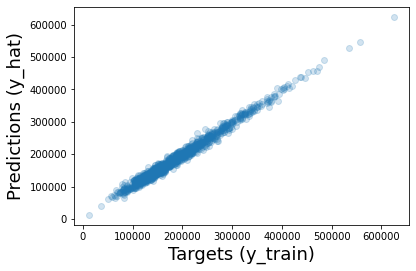

In [ ]:
y_hat = regressor.predict(df_train)

plt.scatter(y_train, y_hat, alpha = 0.2)
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
plt.show()

In [ ]:
regressor.score(df_train,y_train)

0.984484133682734

In [ ]:
accuracies = cross_val_score(estimator = regressor, X = df_train, y = y_train, cv = 10)

[12:00:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:00:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:00:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:00:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:00:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:00:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:00:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:00:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
print(accuracies.mean())
print(accuracies.std())

0.8571918524002662
0.032316454063393237


In [ ]:
use_logvals = 1

pred_xgb = regressor.predict(df_test)

## Make submission

In [ ]:
sub_xgb = pd.DataFrame()
sub_xgb['id'] = sub_id
sub_xgb['target'] = pred_xgb

if use_logvals == 1:
    sub_xgb['target'] = np.exp(sub_xgb['target']) 

sub_xgb.to_csv('sub_xgv.csv',index=False)

submission 파일을 열어 보니

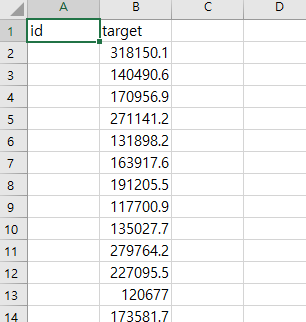

id가 안 들어갔다.

In [ ]:
sub_id

Series([], Name: id, dtype: int64)

- sub_id가 어디갔지

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/숙제/housing_price/submission.csv')
sub

,id,target
0,NaN,318150.100
1,NaN,140490.580
2,NaN,170956.890
3,NaN,271141.220
4,NaN,131898.160
...,...,...
1329,NaN,325777.120
1330,NaN,127539.055
1331,NaN,70847.195
1332,NaN,197869.880


In [ ]:
sub_id = range(1, 1335)
sub_id

range(1, 1335)

In [ ]:
sub_xgb['id'] = sub_id

In [ ]:
# 재시도
sub_xgb = pd.DataFrame()
sub_xgb['id'] = sub_id
sub_xgb['target'] = pred_xgb

if use_logvals == 1:
    sub_xgb['target'] = np.exp(sub_xgb['target']) 

sub_xgb.to_csv('sub_xgb.csv',index=False)

## XGBoost tuning
- Sklearn의 GridSearch 이용

In [ ]:
xg_model = XGBRegressor(n_estimators=100, seed = 1234)

param_dict = {'max_depth': [3,4,5],
              'min_child_weight': [2,3,4],
              'learning_rate': [0.05, 0.1,0.15],
              'gamma': [0.0, 0.1, 0.2]
}

start = time()
grid_search = GridSearchCV(xg_model, param_dict)
grid_search.fit(df_train, y_train)
print("GridSearch took %.2f seconds to complete." % (time()-start))
display(grid_search.best_params_)

[11:34:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

{'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3}

In [ ]:
xg_model = XGBRegressor(n_estimators = 1000,
                        learning_rate = 0.1,
                        max_depth = 3,
                        min_child_weight = 3,
                        gamma = 0,
                        seed = 1234)

xg_model.fit(df_train, y_train)
xg_preds = np.expm1(xg_model.predict(df_test))

[11:34:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
sub = pd.DataFrame()
sub['id'] = sub_id
sub['target'] = xg_preds

In [ ]:
sub.to_csv('XGBoost Submission.csv',index=False)

## XGBOost

**XGBoost(extreme gradient boosting)**

- XGBoost는 Gradient Boosting 알고리즘을 분산환경에서도 실행할 수 있도록 구현해놓은 라이브러리이다.
- Regression, Classification 문제를 모두 지원한다.
- XGBoost는 여러개의 Decision Tree를 조합해서 사용하는 Ensemble 알고리즘이다.

<br/>

**boosting**

- 여러 개의 약한 Decision Tree를 조합하여 사용하는 Ensemble 기법 중 하나
- 약한 예측 모형들의 training error에 가중치를 두고, 순차적으로 다음 학습 모델에 반영하여 강한 예측 모델에

<br/>

**XGBoosting 장점**

- GBM 대비 빠른 수행시간
- 병렬 처리로 학습, 분류 속도가 빠르다.
- 과적합 규제(Regularization)
  - 표준 GBM 경우 과적합 규제기능이 없으나, XGBoost는 자체에 과적합 규제 기능으로 강한 내구성 지닌다.
- 분류와 회귀영역에서 뛰어난 예측 성능 발휘
  - 즉, CART(Classification and regression tree) 앙상블 모델을 사용
- Early Stopping(조기 종료) 기능이 있음
- 다양한 옵션을 제공하며 Customizing이 용이하다.



## Reference

EDA 참고
1. https://dacon.io/competitions/official/235869/codeshare/4390
2. https://rainbowshabet.tistory.com/2

Linear Regression 참고
1. https://www.kaggle.com/code/veronicazheng/house-pricing-using-linear-ridge-lasso-regression/notebook
2. https://github.com/Bashkeel/House-Prices#9-SalePrice-Modelling

## 회고


헷갈리는 점들과 배운 점

1. test set에도 다 똑같이 적용 시켜줘야 한다면 애초에 두 개를 합쳐서 진행하고 train, val, test set으로 split하는 방법도 있지 않았을까
2. y를 log 변환했기에 exp로 다시 바꿔주는 것 같은데 맞는지 잘 모르겠다.
3. modeling을 시작하기 전에, 계속 위로 올라가서 전처리하는 과정을 반복했다.
  - 이때까진 그냥 남들이 해둔 것을 그렇구나 하고 보고 말았는데, 직접 해보니까 feature들에 대한 이해가 많이 필요하다는 것을 느꼈다.
  - sklearn 라이브러리를 잘 알고 있느냐도 중요함을 느낌
4. submission까지 만들어본 것은 처음이었는데, 끝까지 맞게 한 것인지 모르겠는 찝찝한 기분이다.
5. metric에 대한 이해가 많이 떨어진다는 점
6. Xgboost를 하면서 뭔가 더 시도해보고 싶었는데 잘 되지 않았다.
  - 많은 하이퍼파라미터를 튜닝할 때 사용하는 Grid Search, Random Search, Bayesian Optimization의 개념을 공부해야겠다.

<br/>

## 더 공부할 것
- linear regression
- 

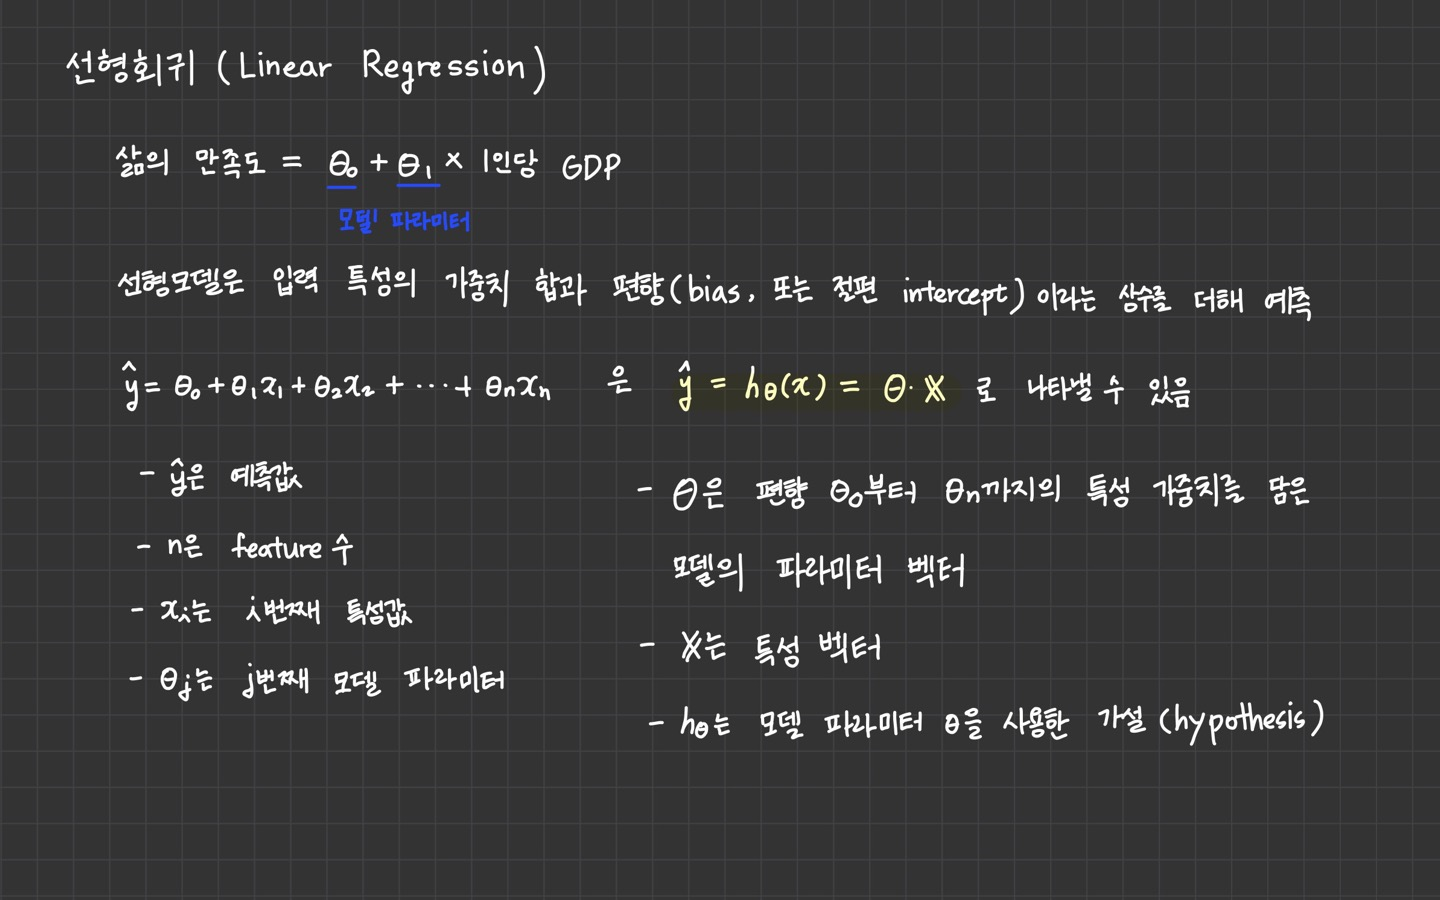

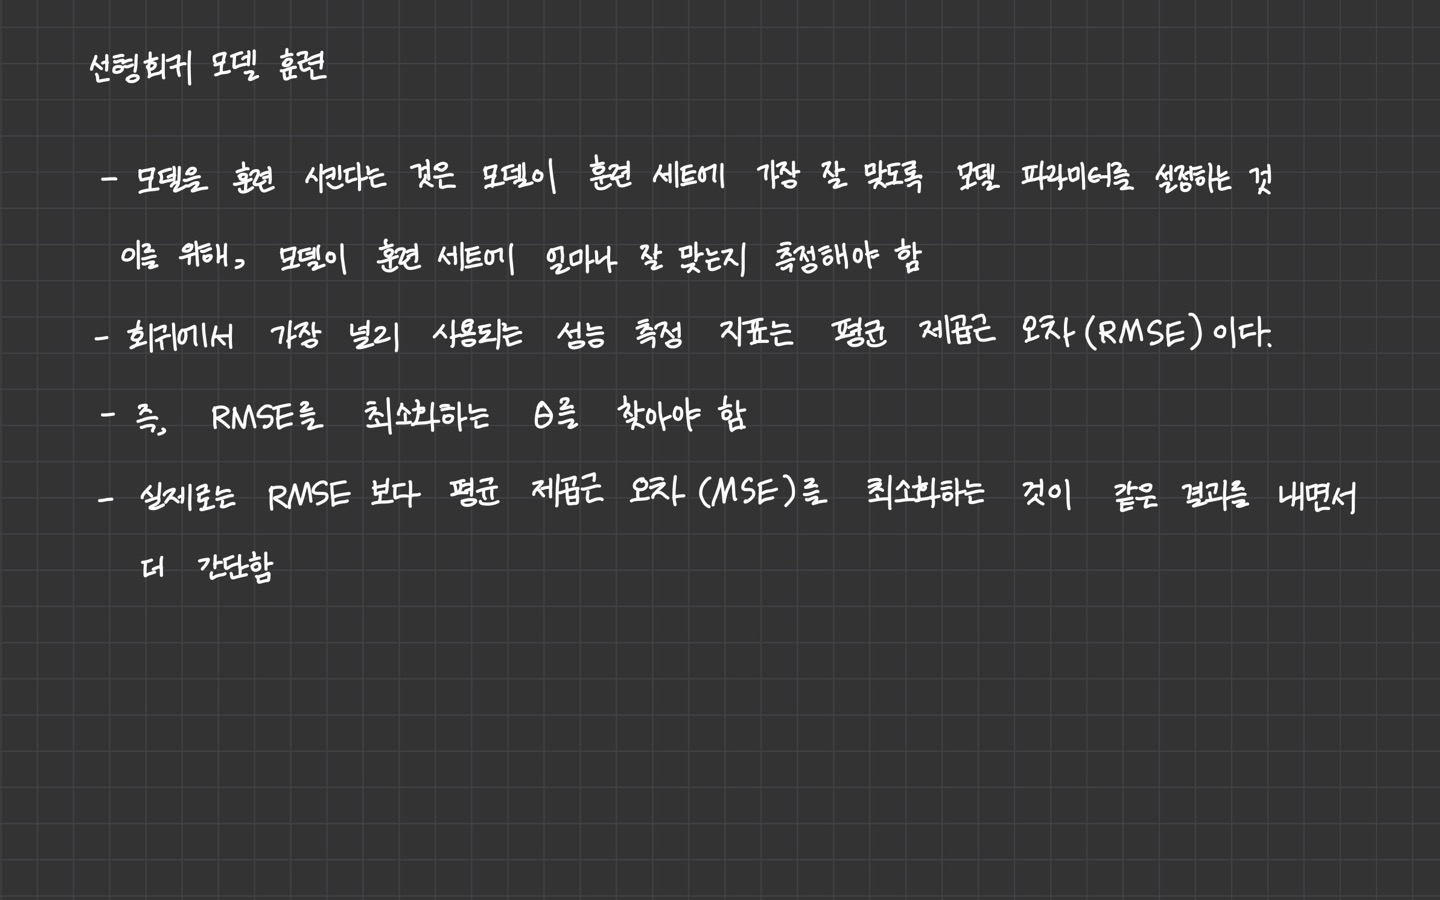

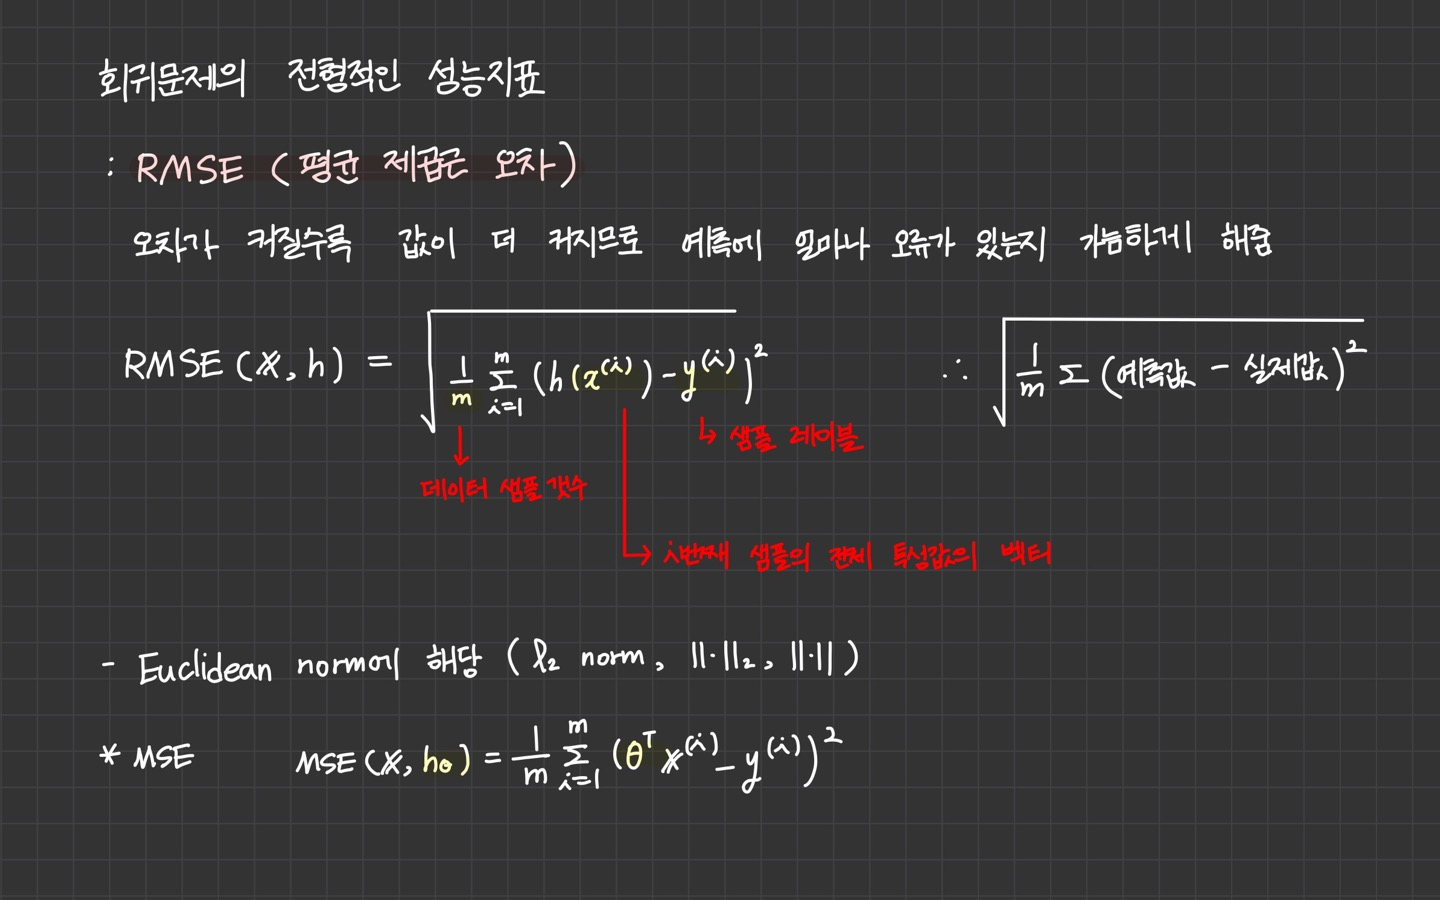

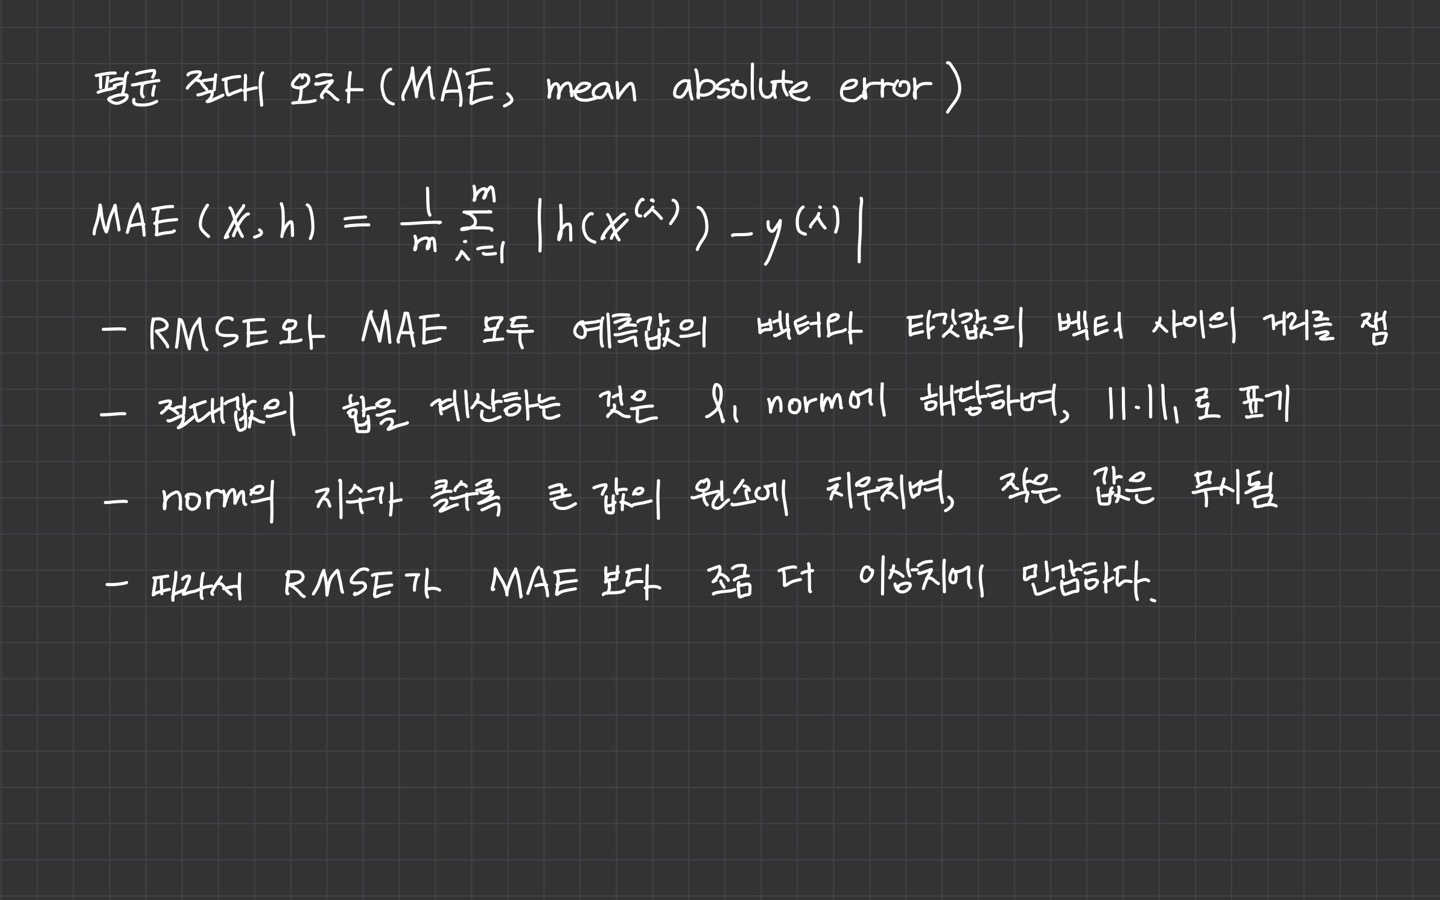